In [8]:
import os
import sys
from collections import Counter
from tkinter import Image

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

Make sure to install all listed libraries, here is the list of their versions:

In [9]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: darwin
Python version: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]
---
matplotlib version: 3.10.6
pandas version: 2.3.2
PIL version: 11.3.0
torch version: 2.8.0
torchvision version: 0.23.0


In [10]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using mps device.


Now we create the transformation algorithm, we need to transform the data to Tensor and convert out photos to gray colored images. Additionally, we need to resize the images to 224*224 for convenience in work when we will be doing MaxPool for example.

In [12]:
class ConvertToL:
    def __call__(self, img):
        if img.mode != "L":
            img = img.convert("L")
        return img

In [13]:
transform = transforms.Compose(
    [
        ConvertToL(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

Now let's write the path to our photos.

In [14]:
train_dir = 'archive'

We will be creating a dataset using the ImageFolder function.

In [15]:
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

Let's take a look on the dataset:

In [16]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)
print(f"We have in total: {len(dataset)} images")

Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
That's 10 classes

Tensor shape for one image:
torch.Size([1, 224, 224])
We have in total: 21555 images


Everything works correccly, since there are indeed 10 classesm and image size is 140x90. But we need to normalize our data, because now each pixel contains the number showing the intensity of the pixel, we need it to be in the range 0-1. We will before that create the data loader, since it would be easier for computation if images are loaded by batches.

In [17]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 1, 224, 224])
Shape of labels: torch.Size([32])


To normalize the data, we need first calculate the mean and standard deviation. After, we will deduct mean from all numbers and then divide it by the standard deviation.

In [18]:
def get_mean_std(loader):


    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [19]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/674 [00:00<?, ?it/s]

Mean: tensor([0.9489])
Standard deviation: tensor([0.1449])


Now, we need to add normalization function to our transform, to normalize the dataset.

In [20]:
transform_norm = transforms.Compose(
    [
        ConvertToL(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [21]:
norm_dataset = datasets.ImageFolder(root = train_dir, transform = transform_norm)

norm_loader = DataLoader(norm_dataset, batch_size=batch_size)

Finally, we have our data prepared. Let's go to training and validation. Just to make sure, we will compute mean and stadard deviation again. As you can see, mean is near 0 while standard deviation is 1.

In [22]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/674 [00:00<?, ?it/s]

Mean: tensor([1.4753e-06])
Standard deviation: tensor([1.0000])


Here we go, we divide the data into two parts. As usual, 20% going to be for validation, while 80% going to be for training the actual data.

In [23]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8,0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


Before proceeding to model creation, we want to make sure that classes nearly equally distributed. That means the same share of each class should be in training and validation sets.

In [24]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})



  0%|          | 0/17244 [00:00<?, ?it/s]

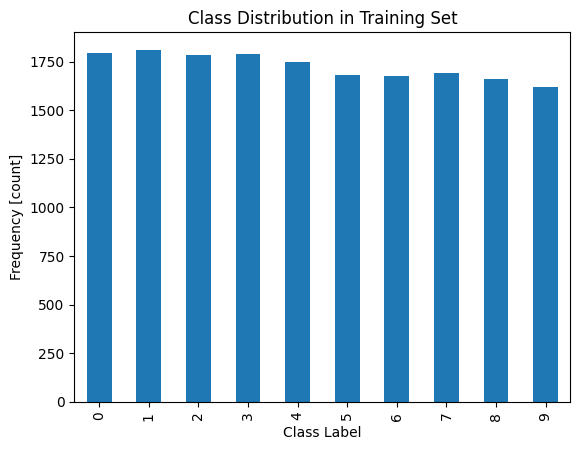

In [25]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions.plot(kind="bar")
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

  0%|          | 0/4311 [00:00<?, ?it/s]

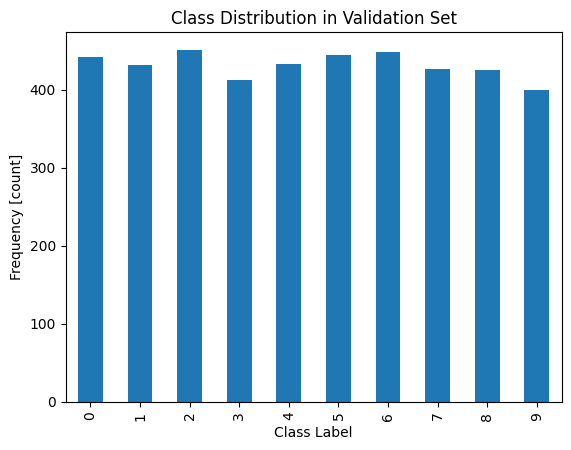

In [26]:
validation_class_distributions = class_counts(val_dataset)
validation_class_distributions.plot(kind="bar")
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

We can see that the distribution is almost identical for both sets. Now we create data loaders for both datasets.

In [27]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 1, 224, 224])


So in one batch, we have 32 images, with each one being 140x90 by size.

For this model, I am going to use convulational architecture as mentioned before, let's build the model.

In [28]:
model_seq = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(4),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(4),
            torch.nn.Flatten(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=3136, out_features=500),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=500, out_features=10),
        )

In [29]:
model_seq

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=3136, out_features=500, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=500, out_features=10, bias=True)
)

In [30]:
test_batch = next(iter(train_loader))[0]
model_seq(test_batch).shape

torch.Size([32, 10])

Summary of the model:

In [31]:
height, width = 224, 224
summary(model_seq, input_size=(batch_size, 1, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 10]                  --
├─Conv2d: 1-1                            [32, 16, 224, 224]        160
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 16, 56, 56]          2,320
├─ReLU: 1-5                              [32, 16, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 16, 14, 14]          --
├─Flatten: 1-7                           [32, 3136]                --
├─Dropout: 1-8                           [32, 3136]                --
├─Linear: 1-9                            [32, 500]                 1,568,500
├─ReLU: 1-10                             [32, 500]                 --
├─Dropout: 1-11                          [32, 500]                 --
├─Linear: 1-12                           [32, 10]                  5,010
T

I will use CrossEntropyLoss function to calculate the cost function, and Adam optimizer for back propagation.

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_seq.parameters(), lr=0.001)
model_seq.to(device)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=3136, out_features=500, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=500, out_features=10, bias=True)
)

In [33]:
def train(model, optimizer, loss_fn, data_loader, device):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [34]:
epochs = 8
for i in range(epochs):
    loss_value = train(model_seq, optimizer, loss_fn, train_loader, device)
    print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.96.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.48.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.36.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.30.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.25.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.22.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.19.


Training:   0%|          | 0/539 [00:00<?, ?it/s]

The average loss during the training epoch was 0.18.


After training the model, we can finally use it.

In [35]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

Let's do the predctions for the validation set and then construct the confusion matrix based on this.

In [36]:
probabilities = predict(model_seq, val_loader, device)
predictions = torch.argmax(probabilities, dim = 1)

Predicting:   0%|          | 0/135 [00:00<?, ?it/s]

In [37]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/135 [00:00<?, ?it/s]

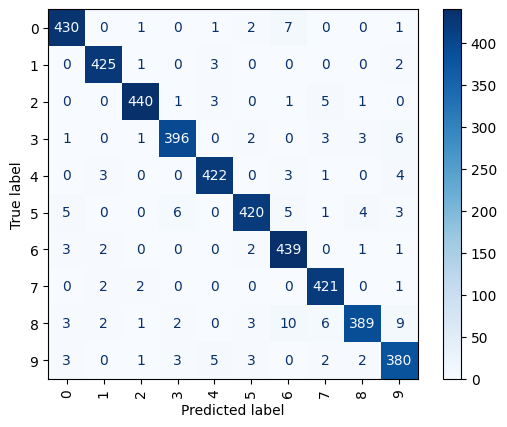

In [40]:
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = dataset.classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

Let's also calculate the accuracy of the model.

In [74]:
targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val = torch.eq(predictions, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val / len(val_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.9654372535374623


96.5% accuracy is great.

In [48]:
torch.save(model_seq, "model_seq.pt")

Now we are fully done! The model is ready and saved.

For the final test, I would like to scan the photo of number my mom wrote to check the model.

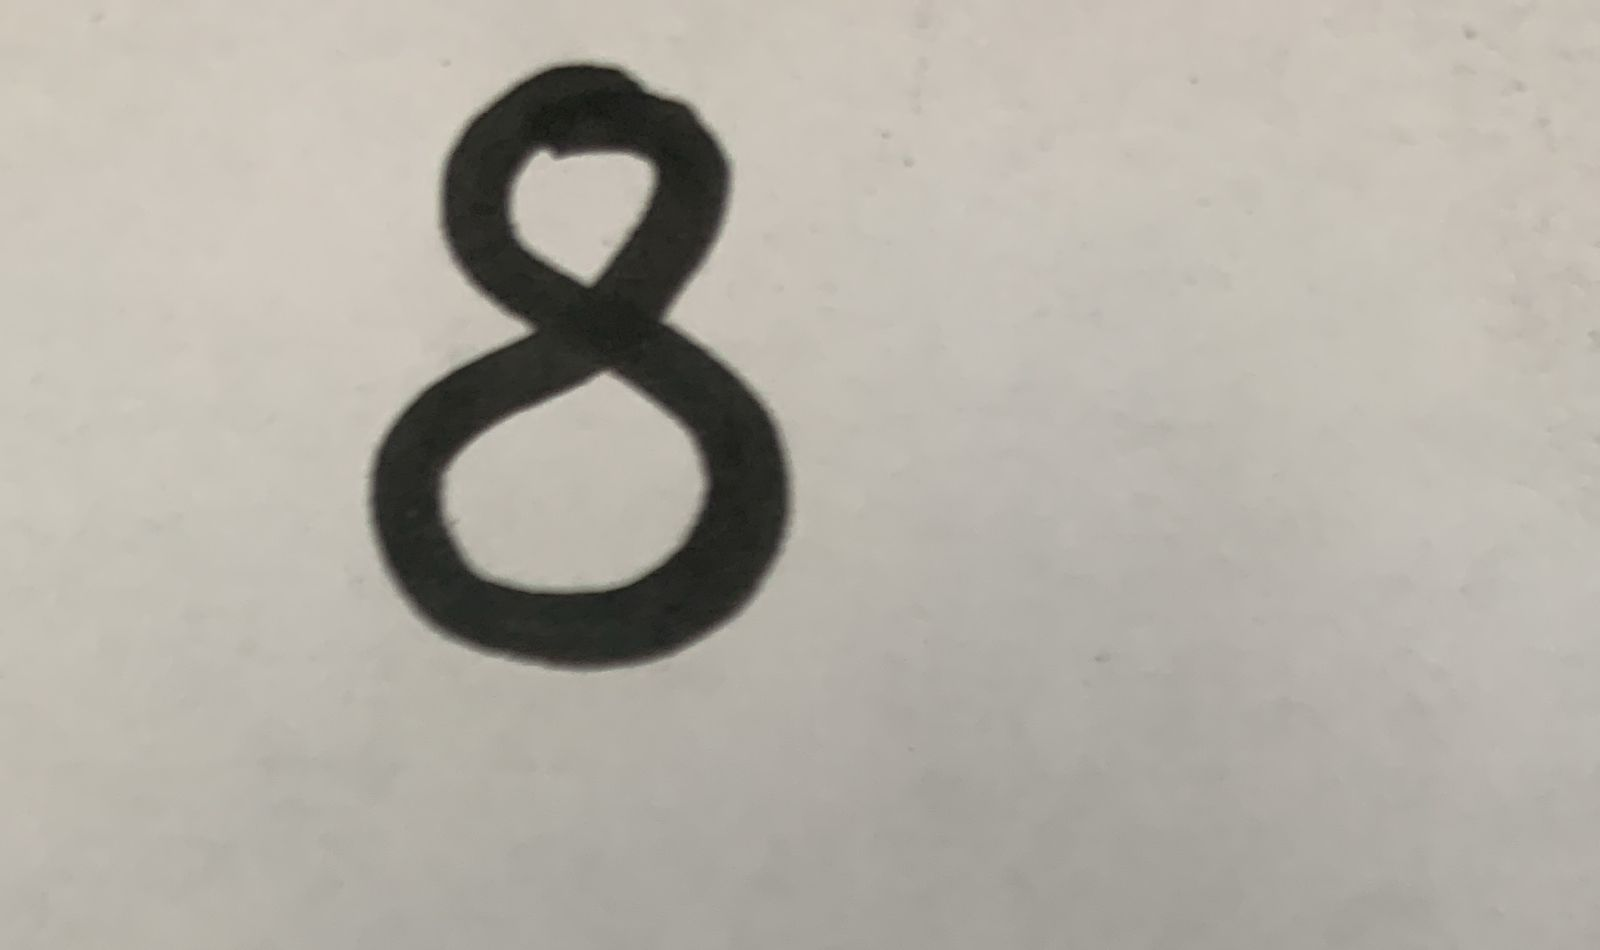

In [75]:
img_path = 'test_image.jpeg'
img_test = PIL.Image.open(img_path)
img_test

In [76]:
def file_to_confidence(file_path, image_id):
    image = PIL.Image.open(file_path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model_seq.eval()
    with torch.no_grad():
        model_raw = model_seq(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    conf_df.index = [image_id]

    return conf_df

In [77]:
file_to_confidence(img_path, 1)

,0,1,2,3,4,5,6,7,8,9
1,0.003648,0.009334,0.019852,0.000443,0.108556,0.018585,0.771928,0.001306,0.048448,0.0179


Unfortunately, model still makes mistakes. May be it is overfitted, may be other reason. I will upgrade the model in future!

I want one more test, but now my photo will be used.

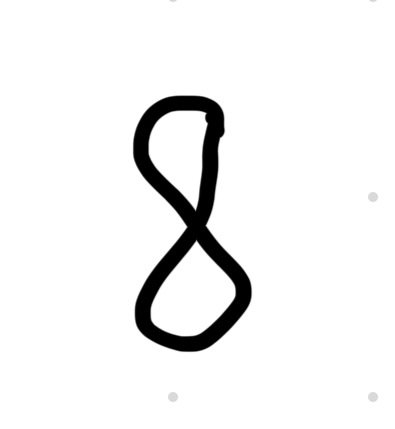

In [78]:
img_path = 'test_image_2.jpeg'
img_test = PIL.Image.open(img_path)
img_test

In [79]:
file_to_confidence(img_path, 2)

,0,1,2,3,4,5,6,7,8,9
2,4.189610e-09,4.411072e-09,0.000002,0.000094,1.998867e-07,2.861069e-09,4.815195e-07,1.382223e-07,0.999656,0.000247


Here we go! Model is 99% that this is number 8!